In [2]:
from vizdoom import*
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import gym 
from gym import Env 
from gym.spaces import Discrete, Box
import cv2
import tensorboard 

In [2]:
#set game
game = DoomGame()
game.load_config("D://New folder//VizDOOM//github//ViZDoom//scenarios//basic.cfg")
game.init()

In [5]:
import numpy as np

In [7]:
actions = np.identity(3,dtype=int)
actions

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [8]:
game.new_episode()

In [9]:
game.is_episode_finished()

False

In [43]:
game.make_action(random.choice(actions))

-1.0

In [ ]:
eps = 10
for i in range(eps):
    game.new_episode()
    while not game.is_episode_finished():
        state = game.get_state()
        img = state.screen_buffer
        info = state.game_variables
        reward = game.make_action(random.choice(actions))
        print("\treward:", reward)
        time.sleep(0.02)
    print("Result:", game.get_total_reward())
    time.sleep(2)

In [3]:
game.close()

In [67]:
game.get_state().screen_buffer.shape 

(3, 240, 320)

In [68]:
game.close()

In [4]:
Discrete(3).sample()

0

In [61]:
actions[Discrete(3).sample()]

array([1, 0, 0])

In [3]:
class VizDoomGym(Env):
    def __init__(self,render=False):
        super().__init__()
        self.game = DoomGame()
        self.game.load_config("D://New folder//VizDOOM//github//ViZDoom//scenarios//basic.cfg")
        if render==False:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
        self.game.init()
        #Action Space and observation space
        self.action_space = Discrete(3)
        self.observation_space = Box(low=0,high=255,shape=(100,160,1),dtype=np.uint8)
    
    def step(self,action):
        actions = np.identity(3,dtype=int)
        reward = self.game.make_action(actions[action],4) #framesk1p = 4

        if self.game.get_state():
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)
            ammo = self.game.get_state().game_variables[0]
            info =ammo
        else:
            state = np.zeros(self.observation_space.shape)
            info = 0
        
        info = {'info':info}
        
        done = self.game.is_episode_finished()
        return state,reward,done,info
    def render():
        pass
    def reset(self):
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        state = self.grayscale(state)
        return state
    def grayscale(self,observation):
        #cut the HUD 
        gray = cv2.cvtColor(np.moveaxis(observation,0,-1),cv2.COLOR_RGB2GRAY)
        resize = cv2.resize(gray,(160,100),interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize,(100,160,1))
        return state
    def close(self):
        self.game.close()

In [11]:
env = VizDoomGym(render=True)

In [12]:
state = env.reset()

In [13]:
state.shape

(100, 160, 1)

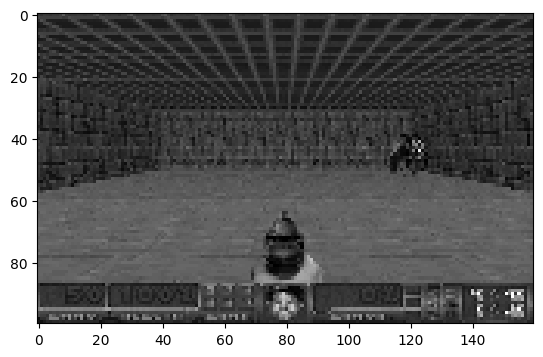

In [15]:
plt.imshow(cv2.cvtColor(state,cv2.COLOR_BGR2RGB))

In [4]:
##Callbacks
import os 
from stable_baselines3.common.callbacks import BaseCallback

In [5]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self,check_freq,save_path,verbose=1):
        super(TrainAndLoggingCallback,self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
    
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path,exist_ok=True)
    
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            self.model.save(self.save_path+f"model_{self.n_calls}_steps")
        return True

In [6]:
CHECKPOINT_DIR = 'D:/New folder/VizDOOM'
LOG = 'D:/New folder/VizDOOM/'

In [7]:
callback = TrainAndLoggingCallback(check_freq=1000,save_path=CHECKPOINT_DIR)

In [8]:
##PPO
from stable_baselines3 import PPO

In [9]:
env = VizDoomGym(render=False)

In [12]:
model = PPO("CnnPolicy",env,verbose=1,tensorboard_log=LOG,learning_rate=0.0001,device='cuda',n_steps=256)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [13]:
model.learn(total_timesteps=100000,callback=callback)

Logging to D:/New folder/VizDOOM/PPO_5
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.6     |
|    ep_rew_mean     | -27.7    |
| time/              |          |
|    fps             | 41       |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 256      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 21.2        |
|    ep_rew_mean          | -21         |
| time/                   |             |
|    fps                  | 34          |
|    iterations           | 2           |
|    time_elapsed         | 15          |
|    total_timesteps      | 512         |
| train/                  |             |
|    approx_kl            | 0.011867528 |
|    clip_fraction        | 0.0621      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.000

KeyboardInterrupt: 

In [14]:
#save model
model.save("D:/New folder/VizDOOM/ppo_model")

In [30]:
env.close()

In [16]:
from stable_baselines3.common.evaluation import evaluate_policy

In [15]:
load_model = PPO.load("D:/New folder/VizDOOM/ppo_model")

In [17]:
env = VizDoomGym(render=True)

In [19]:
mean_reward,_ = evaluate_policy(load_model,env,n_eval_episodes=100)

KeyboardInterrupt: 

In [21]:
env.close()

In [ ]:
llll